In [1]:
import h5py
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import sys
sys.path.append('/mnt/mnt/4TB_pcie/fastBrain/')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias')
sys.path.append('/mnt/mnt/5TB_slot2/Tobias/TobiasPy/fastMRI')
import torch
from torch.utils.data import DataLoader
from common.args import Args
import net_utils as nu
import sigpy as sp
import sigpy.plot as pl
%matplotlib notebook
import argparse
import pathlib
from skimage.metrics import structural_similarity as np_ssim
import vd_spiral

%load_ext autoreload
%autoreload 2

In [2]:
sys.argv=['']
def create_arg_parser():
    parser = argparse.ArgumentParser(description="ML parameters")
    parser.add_argument('--num-pools', type=int, default=4, help='Number of U-Net pooling layers')
    parser.add_argument('--drop-prob', type=float, default=0.0, help='Dropout probability')
    parser.add_argument('--num-chans', type=int, default=32, help='Number of U-Net channels')

    parser.add_argument('--batch-size', default=8, type=int, help='Mini batch size')
    parser.add_argument('--num-epochs', type=int, default=500, help='Number of training epochs')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rate')
    parser.add_argument('--lr-step-size', type=int, default=40,
                        help='Period of learning rate decay')
    parser.add_argument('--lr-gamma', type=float, default=0.1,
                        help='Multiplicative factor of learning rate decay')
    parser.add_argument('--weight-decay', type=float, default=0.,
                        help='Strength of weight decay regularization')

    parser.add_argument('--report-interval', type=int, default=100, help='Period of loss reporting')
    parser.add_argument('--data-parallel', default=True,
                        help='If set, use multiple GPUs using data parallelism')
    parser.add_argument('--device', type=str, default='cuda',
                        help='Which device to train on. Set to "cuda" to use the GPU')
    parser.add_argument('--exp-dir', type=pathlib.Path, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/train/spiral',
                        help='Path where model and results should be saved')
    parser.add_argument('--resume', action='store_true', default=False,
                        help='If set, resume the training from a previous model checkpoint. '
                             '"--checkpoint" should be set with this')
    parser.add_argument('--checkpoint', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/train/unet_spiral/model.pt',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--logdir', type=str, default='/mnt/mnt/5TB_slot2/Tobias/Thesis/log/spiral_unet',
                        help='Path to an existing checkpoint. Used along with "--resume"')
    parser.add_argument('--seed', default=42, type=int, help='Seed for random number generators')
    parser.add_argument('--resolution', default=320, type=int, help='Resolution of images')
    parser.add_argument('--device_ids', default=[0,1] , help='GPUS used')
    return parser
args=create_arg_parser().parse_args()

In [3]:
file='/mnt/mnt/4TB_pcie/fastBrain/multicoil_train/file_brain_AXFLAIR_200_6002425.h5'
with h5py.File(file,'r') as f:
    print("Keys: %s"%f.keys())
    data=np.array(list(f['kspace']))
    f.close()

Keys: <KeysViewHDF5 ['ismrmrd_header', 'kspace', 'reconstruction_rss']>


(20, 320, 320)
k-space array shape: (20, 96, 512)
coordinate array shape: (96, 512, 2)


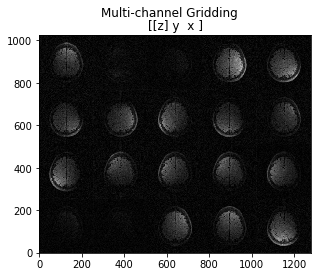

CPU times: user 84.9 ms, sys: 26.1 ms, total: 111 ms
Wall time: 110 ms


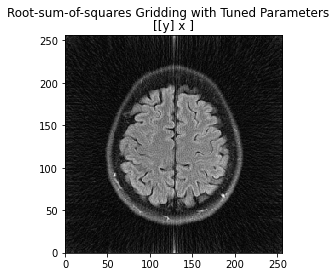

In [4]:
img=abs(nu.make_ift(data))[8,:,160:480,:]
#pl.ImagePlot(img,z=0,title='Original')
print(img.shape)
coord = np.load('projection_coord.npy')
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
#coord=coord.reshape(-1, coord.shape[-1])
ksp = sp.nufft(img, coord,3)

print('k-space array shape: {}'.format(ksp.shape))
print('coordinate array shape: {}'.format(coord.shape))

img_grid = sp.nufft_adjoint(ksp * dcf, coord)
pl.ImagePlot(img_grid, z=0, title='Multi-channel Gridding')

%time img_grid_tune = sp.nufft_adjoint(ksp * dcf, coord, oversamp=1, width=2)
img_rss_tune = np.sum(np.abs(img_grid_tune)**2, axis=0)**0.5
pl.ImagePlot(img_rss_tune, title='Root-sum-of-squares Gridding with Tuned Parameters')

102400
(16, 20, 640, 320)
(2, 34133)
(33920, 2)


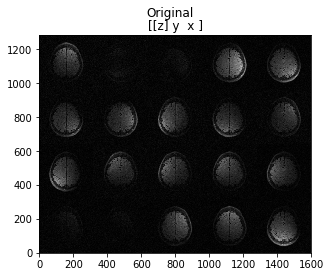

(20, 320, 320)


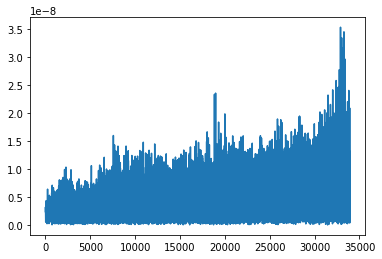

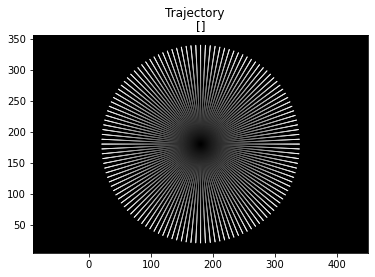

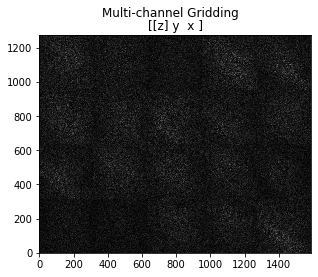

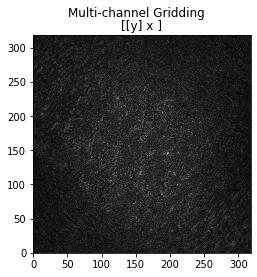

In [73]:
full=args.resolution*args.resolution
print(full)
us_factor=3
#N=30000;
N=full//us_factor
print(data.shape)
nRounds=100;
PowCoeff=2; 
m_size=320;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);
print(traj.shape)

traj=vd_spiral.makeRadial(N,128,m_size//2)
print(traj.shape)
img=abs(nu.make_ift(data))[8,:,160:480,:]
pl.ImagePlot(img,z=0,title='Original')
print(img.shape)
ksp = sp.nufft(img, traj)
plt.plot(abs(ksp)[8])
dcf = (abs(traj[:,0]-180)**2 + abs(traj[:,1]-180)**2)**0.5
pl.ScatterPlot(traj, dcf, title='Trajectory')
img_grid = sp.nufft_adjoint(ksp*dcf, traj)
pl.ImagePlot(img_grid,z=0,title='Multi-channel Gridding')
pl.ImagePlot(nu.rsos(img_grid,0),title='Multi-channel Gridding')

102400
25600
(25600, 2)
(20, 320, 320)


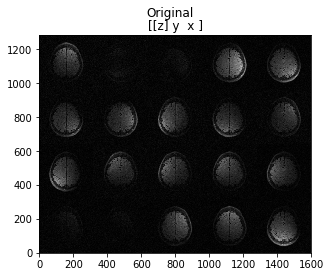

(20, 320, 320)


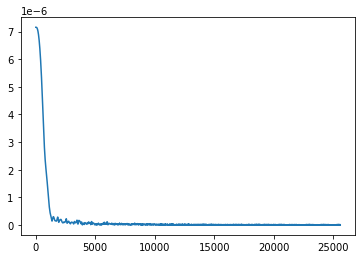

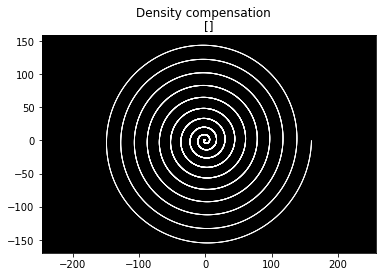

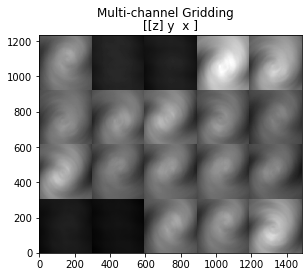

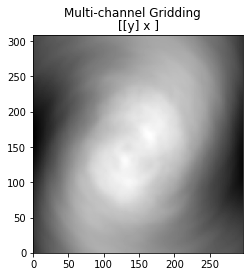

In [69]:
full=args.resolution*args.resolution
print(full)
us_factor=4
#N=30000;
N=full//us_factor
print(N)
nRounds=10;
PowCoeff=1.4; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);
traj=np.swapaxes(traj,0,1)
print(traj.shape)
img=abs(nu.make_ift(data))[8,:,160:480,:]
print(img.shape)
pl.ImagePlot(img,z=0,title='Original')
print(img.shape)
ksp = sp.nufft(img, traj,3)
plt.plot(abs(ksp)[8])
#dcf = (traj[..., 0]**2 + traj[..., 1]**2)**0.5
dcf=np.array([1 for i in range(traj.shape[0])])
pl.ScatterPlot(traj, dcf, title='Density compensation')
img_grid = sp.nufft_adjoint(ksp, traj)
pl.ImagePlot(img_grid,z=0,title='Multi-channel Gridding')
pl.ImagePlot(nu.rsos(img_grid,0),title='Multi-channel Gridding')

In [49]:
def check_density(traj,d=[],r0=1):
    d_p=[]
    temp=1
    r=r0
    rs=[]
    for i in range(len(traj)):
        #print((traj[i, 0]**2 + traj[i, 1]**2)**0.5)
        #print("r",r)
        if (traj[i, 0]**2 + traj[i, 1]**2)**0.5>r:
            #print(r)
            d.append(temp)
            for i in range(temp-1):
                d_p.append(temp)
            rs.append(r)
            temp=1
            r=np.sqrt(r0+r**2)
            while (traj[i, 0]**2 + traj[i, 1]**2)**0.5>r:
                d.append(temp)
                r=np.sqrt(r0+r**2)
                rs.append(r)
            temp=2
        else:
            temp+=1
    d.append(temp)
    for i in range(temp-1):
        d_p.append(temp)
    #print(d)
    return np.array(d),np.array(rs),np.array(d_p)

In [50]:
dcf,rs,d_p=check_density(traj)
print(np.sum(dcf))
print(dcf.shape)
print(rs)

41911
(16311,)
[  1.           1.41421356   1.73205081 ... 127.70277992 127.7066952
 127.71061037]


In [51]:
def get_dcf(points,dcf,rs):
    for i in range(len(points)):
        for j in range(len(points[i])):
            print(j)
            idx=0
            while (i-args.resolution)**2 + (j-args.resolution)**2>rs[idx]:
                if idx==len(rs)-1:
                    break
                idx+=1
            points[i,j]=points[i,j]*1/dcf[idx]
    return points

def apply_dcf(ksp,dp):
    return ksp/dp

In [52]:
print(apply_dcf(ksp,d_p))

[[ 4.66706691e-09-3.26518663e-26j  4.66707688e-09-3.87928305e-14j
   4.66709328e-09-1.02596706e-13j ...  2.64103376e-09+6.39752970e-10j
   3.05915045e-09+1.01013808e-09j  3.29553077e-09+8.05090347e-10j]
 [ 3.95409670e-09-2.41865676e-26j  3.95410384e-09-2.46209166e-14j
   3.95411558e-09-6.49947816e-14j ... -9.55995498e-10+1.51516201e-09j
   2.14243862e-10+6.07445696e-10j  2.30068314e-09-5.76562062e-11j]
 [ 1.09474005e-08-4.83731352e-26j  1.09474406e-08-9.71162596e-14j
   1.09475067e-08-2.57975321e-13j ... -6.09958748e-10-2.22771057e-09j
  -1.97206409e-09-1.29001210e-09j -3.01869023e-09-4.71906920e-10j]
 ...
 [ 5.06350276e-09-2.26749071e-26j  5.06351355e-09+9.41837086e-15j
   5.06353129e-09+2.46668822e-14j ...  3.71023006e-10-3.79175452e-10j
   2.40786867e-09-3.88936649e-10j  5.00445532e-09-1.50747048e-10j]
 [ 1.57489127e-08-5.32104488e-26j  1.57489745e-08+3.52690551e-13j
   1.57490762e-08+9.27387013e-13j ... -2.46314231e-09-2.09018047e-09j
  -2.24480029e-09-2.90574231e-10j -2.04056163e-

102400
12800
(16, 20, 640, 320)
(20, 320, 320)


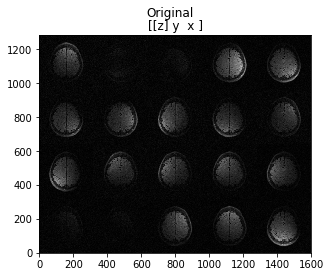

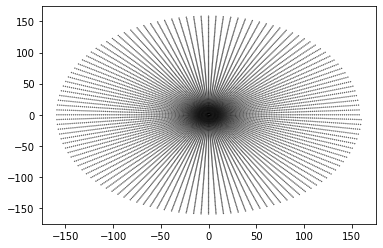

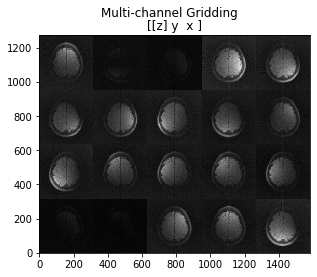

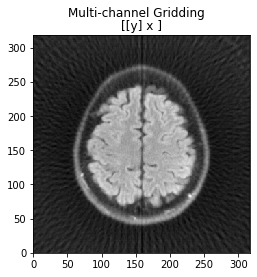

In [66]:
full=args.resolution*args.resolution
print(full)
us_factor=8
#N=30000;
N=full//us_factor
print(N)
nRounds=100;
PowCoeff=1.4; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);

traj=np.swapaxes(traj,0,1)
print(data.shape)
img=abs(nu.make_ift(data))[8,:,160:480,:]
print(img.shape)
pl.ImagePlot(img,z=0,title='Original')
ksp = sp.nufft(img, traj,3)
plt.scatter(traj[:,0],traj[:,1], c=np.real(ksp[8]),s=0.1)
plt.gray()
plt.show()
dcf,rs,d_p=check_density(traj,r0=1)
img_grid = sp.nufft_adjoint(apply_dcf(ksp,d_p), traj)
pl.ImagePlot(img_grid,z=0,title='Multi-channel Gridding')
pl.ImagePlot(nu.rsos(img_grid,0),title='Multi-channel Gridding')

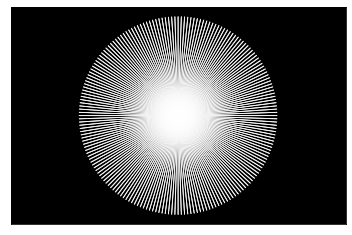

In [54]:
coord = np.load('projection_coord.npy')
dcf = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
dcf=coord[..., 0]/coord[..., 0]
pl.ScatterPlot(coord, dcf, title='Density compensation',hide_axes=True)
plt.show()

102400
25600


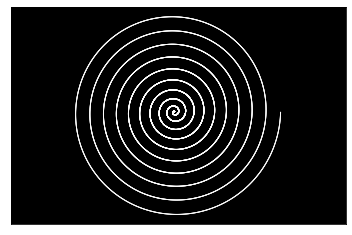

In [55]:
full=args.resolution*args.resolution
print(full)
us_factor=4
#N=30000;
N=full//us_factor
print(N)
nRounds=10;
PowCoeff=1.4; 
m_size=160;
p_base=0;
traj=vd_spiral.makeSpiral(N,nRounds,PowCoeff,p_base,m_size);
traj=np.swapaxes(traj,0,1)
#dcf = (traj[..., 0]**2 + traj[..., 1]**2)**0.5
dcf=np.array([1 for i in range(traj.shape[0])])
pl.ScatterPlot(traj, dcf, title='Density compensation',hide_axes=True)

torch.Size([300, 500])


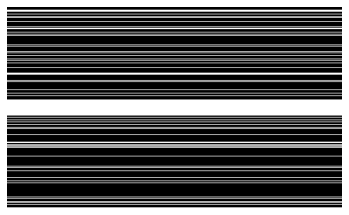

In [87]:
full=nu.apply_mask(torch.from_numpy(np.ones((300,500))).unsqueeze(0),mode="random")[0].squeeze(0)
print(full.shape)
plt.imshow(full==0,cmap="binary")
plt.axis("off")
plt.show()

torch.Size([300, 500])


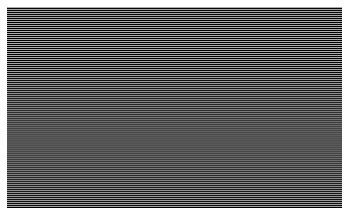

In [89]:
full=nu.apply_mask(torch.from_numpy(np.ones((1,300,500))).unsqueeze(0),r=3,mode="plain")[0][0].squeeze(0)
print(full.shape)
plt.imshow(full==0,cmap="binary")
plt.axis("off")
plt.show()